In [2]:
import numpy as np
import pandas as pd
import math

import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import concatenate
import tensorflow_addons as tfa
from keras.layers import Flatten, Dense, Dropout
import tifffile

from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer, normalize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
import os

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN 
from collections import Counter

import scipy
from numba import cuda 

In [3]:
# !pip install numpy tensorflow matplotlib scipy
# # !pip install pandas
# !pip install tifffile
# !pip install scikit-learn
# !pip install imagecodecs
# !pip install tensorflow-addons
# !pip install numba
# !pip install ipyplot
!pip install imbalanced-learn

In [4]:
def reset_gpu():
    device = cuda.get_current_device()
    device.reset()

In [5]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
   # plt.plot(history.history['accuracy'], label='accuracy')
   # plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.ylim([0, 
            max(
                max(history.history['loss']),
                max(history.history['val_loss'])
            )])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

In [103]:
# tiles = pd.read_csv(r'Data/Tiles_expanded.csv')
tiles_expanded_rv = pd.read_csv(r'Data/Tiles_TRAIN.csv')#.drop(['Unnamed: 0'],axis=1)
# tiles_expanded_rv = pd.get_dummies(tiles_expanded_rv, columns = ['RTTYP'])

In [7]:
tiles_expanded_rv.head()

,Tile_ID,Stop_Signs,Paving_historical,Bus_stop,Collisions_Historical,RTTYP_I,RTTYP_M,RTTYP_O,RTTYP_S,RTTYP_U,...,94129,94130,94131,94132,94133,94134,94141,94143,94158,94188
0,10993,0.0,0.0,0.0,2.0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,13338,0.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10163,0.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7523,1.0,0.0,1.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10314,2.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [105]:
tiles_expanded_rv['bins_numeric'].value_counts()

0     6644
2     1201
3      283
1      134
6       61
4       26
7       14
5        5
8        4
10       3
9        1
Name: bins_numeric, dtype: int64

In [106]:
tiles_test_rv = pd.read_csv(r'Data/Tiles_TEST.csv')

In [108]:
tiles_test_rv['bins_numeric'].value_counts()

0    1646
2     304
3      72
1      43
6      11
4      10
7       4
8       2
5       2
9       1
Name: bins_numeric, dtype: int64

In [8]:
# tiles_expanded_rv['Collisions_Future_binary']=tiles_expanded_rv['Collisions_Future'].apply(lambda x: 1 if x > 0 else 0)
# tiles_expanded_rv['Collisions_Historical_binary']=tiles_expanded_rv['Collisions_Historical'].apply(lambda x: 1 if x > 0 else 0)

In [9]:
# tiles_expanded_rv['bins_numeric'], bin_keys = pd.factorize(tiles_expanded_rv['bins_numeric'])
# tiles_expanded_rv.columns

In [10]:
# bin_keys
# tiles_expanded_rv.columns

In [11]:
tiles_expanded_rv['bins_numeric'].value_counts()

0     6644
2     1201
3      283
1      134
6       61
4       26
7       14
5        5
8        4
10       3
9        1
Name: bins_numeric, dtype: int64

# Normalize data

In [12]:
# def normalize_col(df, col_name):

#     norm = (df[col_name] - df[col_name].min()) / (df[col_name].max() - df[col_name].min())
#     return norm

# tiles_expanded_rv['Mid_lat_norm'] = normalize_col(tiles_expanded_rv,'Mid_lat')
# tiles_expanded_rv['Mid_long_norm'] = normalize_col(tiles_expanded_rv,'Mid_long')


Split into training and test

In [54]:
MODEL_TYPE='logistic' # 'linear'

if MODEL_TYPE == 'linear':
    input_x = ['Tile_ID','Collisions_Historical', 'Mid_lat_norm','Mid_long_norm', 'Stop_Signs', 'Paving_historical', 'Bus_stop','RTTYP_I','RTTYP_M','RTTYP_S','RTTYP_U'] # Removing RTTYP_O
    input_y = ['Collisions_Future']
elif MODEL_TYPE == 'logistic':
    input_x = ['Tile_ID', 'Stop_Signs', 'Paving_historical', 'Bus_stop',
       'Collisions_Historical', 'RTTYP_I', 'RTTYP_M', 'RTTYP_O', 'RTTYP_S',
       'RTTYP_U', '94101', '94102', '94104', '94105', '94107',
       '94108', '94109', '94110', '94111', '94112', '94114', '94115', '94116',
       '94117', '94118', '94121', '94122', '94123', '94124', '94127', '94129',
       '94130', '94131', '94132', '94133', '94134', '94141', '94143', '94158',
       '94188']
    input_y = ['bins_numeric']
    

x_train, x_test, y_train, y_test = train_test_split(
                                    tiles_expanded_rv[input_x], 
                                    tiles_expanded_rv[input_y],
                                    random_state=104, 
                                    test_size=0.20, 
                                    shuffle=True)



### Oversampling using SMOTE

In [55]:

counter = Counter(y_train['bins_numeric'])
print(counter)
ros = RandomOverSampler(random_state=0,sampling_strategy={0:5297, 2:968, 3:230, 1:230, 6:150, 4:100, 7:100, 5:100,10:100,8:100,9:100})
x_train, y_train = ros.fit_resample(x_train, y_train)
counter_sampled = Counter(y_train['bins_numeric'])
print(counter_sampled)
# smote_enn = SMOTEENN(random_state=0,sampling_strategy='minority')

# x_train_sampled, y_train_sampled = smote_enn.fit_resample(x_train, y_train)
# print(sorted(Counter(y_train_sampled).items()))

Counter({0: 5297, 2: 968, 3: 230, 1: 108, 6: 53, 4: 22, 7: 11, 5: 4, 10: 3, 8: 3, 9: 1})
Counter({0: 5297, 2: 968, 3: 230, 1: 230, 6: 150, 7: 100, 10: 100, 4: 100, 5: 100, 8: 100, 9: 100})


In [56]:
class_weight_list = compute_class_weight(class_weight='balanced',classes=y_train['bins_numeric'].unique(), y=y_train['bins_numeric'].to_numpy())

In [57]:
print(class_weight_list)


[0.12828874 2.95454545 0.70200977 6.79545455 2.95454545 4.53030303
 6.79545455 6.79545455 6.79545455 6.79545455 6.79545455]


In [58]:
class_weight={}
unique_classes = y_train['bins_numeric'].unique()
for i in range(11) :
    class_weight[unique_classes[i]] = class_weight_list[i]

In [59]:
print(unique_classes)

[ 0  3  2  7  1  6 10  4  5  8  9]


Model #1: Linear regression using Historical Collisions, SFMTA Street Characteristics, and Geocoordinates

## Image Pre-Processing

In [60]:
IMAGE_PATH = 'Satellite_Imagery/Satellite_Images_Tiled/' 

In [61]:
 #eda
img = tifffile.imread('Satellite_Imagery/Satellite_Images_Tiled/36.tif')[0:148, 0:188, :]
img2 = tifffile.imread('Satellite_Imagery/Satellite_Images_Tiled/37.tif')[0:148, 0:188, :]

In [62]:
# eda
print(np.shape(img2))

(148, 188, 4)


In [63]:
# eda
test = []
test.append(img[0:148, 0:188, :])
test.append(img2[0:148, 0:188, :])
print(np.shape(test))
test = np.stack(test)
print(np.shape(test))

(2, 148, 188, 4)
(2, 148, 188, 4)


In [64]:
def preprocess_data_part1(IMAGE_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 149 3)
    """
    
    data_mini = []
    data_mini_test = []
    for id in x_train['Tile_ID']:    
                    
        # read image and store as matrix            
        # Index at the end makes all images the same size (they sometimes differ by 1 pixel)
        image = tifffile.imread(IMAGE_PATH + str(id) + '.tif')[0:148, 0:188, :]
            
        # append to images
        data_mini.append(image)
 
    # stack images and trasnform to array
    images_mini = np.stack(data_mini)
    
    for id in x_test['Tile_ID']:    
                    
        # read image and store as matrix            
        # Index at the end makes all images the same size (they sometimes differ by 1 pixel)
        image = tifffile.imread(IMAGE_PATH + str(id) + '.tif')[0:148, 0:188, :]
            
        # append to images
        data_mini_test.append(image)
 
    # stack images and trasnform to array
    images_mini_test = np.stack(data_mini_test)
    
    return images_mini, images_mini_test


In [65]:
# THERE IS ONE FILE IN THE "SATELLITE IMAGES TILED" FOLDER THAT IS NOT A TIF IMAGE, DELETE THIS FILE
images_mini, images_mini_test = preprocess_data_part1(IMAGE_PATH)
# images_mini = np.load('/home/ubuntu/210_Capstone_Aditya_Arisa_Noriel/Data/train.npy')
# images_mini_test = np.load('/home/ubuntu/210_Capstone_Aditya_Arisa_Noriel/Data/test.npy')

In [66]:
np.shape(images_mini)
np.shape(images_mini_test)

(1676, 148, 188, 4)

In [67]:
# with open('/home/ubuntu/210_Capstone_Aditya_Arisa_Noriel/Data/train.npy', 'wb') as f:
#     np.save(f,images_mini)

In [68]:
# with open('/home/ubuntu/210_Capstone_Aditya_Arisa_Noriel/Data/test.npy', 'wb') as f:
#     np.save(f,images_mini_test)
# # images_mini_reshaped = images_mini.reshape((8376,1,1,111296))

In [69]:
# images_mini_reshaped.shape
# len(images_mini_reshaped[0][0][0])

Street Data Pre-Processing

In [70]:
x_train

,Tile_ID,Stop_Signs,Paving_historical,Bus_stop,Collisions_Historical,RTTYP_I,RTTYP_M,RTTYP_O,RTTYP_S,RTTYP_U,...,94129,94130,94131,94132,94133,94134,94141,94143,94158,94188
0,1526,0.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,11426,0.0,7.0,0.0,8.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,13993,0.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,3201,0.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,13779,0.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7470,9476,1.0,0.0,0.0,17.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7471,9476,1.0,0.0,0.0,17.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7472,12726,0.0,3.0,5.0,11.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7473,10746,0.0,0.0,4.0,11.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
street = np.asarray(x_train[input_x[1:]]).astype('float32')
street_mini = []
for row in street:
    street_mini.append([[row]])
street_mini = np.stack(street_mini)
np.shape(street_mini)


street_test = np.asarray(x_test[input_x[1:]]).astype('float32')
street_mini_test = []
for row in street_test:
    street_mini_test.append([[row]])
street_mini_test = np.stack(street_mini_test)
np.shape(street_mini_test)

(1676, 1, 1, 39)

In [72]:
print(street_mini.shape)
print(images_mini.shape)

(7475, 1, 1, 39)
(7475, 148, 188, 4)


In [73]:
input_image_street = np.hstack(
    (street_mini.reshape((7475,39)),
    normalize(images_mini.reshape(7475,-1))
     # images_mini.reshape(8376,148*188*4)
    )
)

In [74]:
print(street_mini_test.shape)
print(images_mini_test.shape)

(1676, 1, 1, 39)
(1676, 148, 188, 4)


In [75]:
input_image_street_test = np.hstack(
    (street_mini_test.reshape((1676,39)),
    # images_mini_test.reshape((2095,148*188*4))
    normalize(images_mini_test.reshape(1676,-1))
    ))

In [76]:
input_image_street_test.shape

(1676, 111335)

## Linear Regression

In [77]:
# x: 'Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop','RTTYP_I','RTTYP_M','RTTYP_O','RTTYP_S','RTTYP_U'
# y: 'Collisions_Future'

def create_linear_model():
    # DENSE LAYERS 
    input = tf.keras.layers.Input(shape=(111306,))

    outputs = layers.Dense(1)(input)

    linear_model = tf.keras.models.Model(inputs=input, outputs=outputs, name="linear_model")

    linear_model.summary()

    linear_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_squared_error'
        )
    
    return linear_model

# linear_model = create_linear_model()

# history = linear_model.fit(
#     input_image_street,
#      np.stack(y_train['Collisions_Future'].to_numpy()),
#     epochs=100,
#     # Suppress logging.
#      verbose=1,
#     # Calculate validation results on 20% of the training data.
#     validation_split = 0.2)


In [78]:
# plot_loss(history)

In [79]:
# predict_result = history.model.predict(input_image_street_test)

In [80]:
# predict_result.shape

## Mean squared error

In [81]:
# np.square(predict_result - y_test['Collisions_Future'].to_numpy().reshape((649,1))).mean()
tiles_expanded_rv['bins_numeric'].value_counts()

0     6644
2     1201
3      283
1      134
6       61
4       26
7       14
5        5
8        4
10       3
9        1
Name: bins_numeric, dtype: int64

In [82]:
tf.keras.backend.clear_session()

## LOGISTIC MODEL WITH IMAGES

Model: "logistic_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 111335)]          0         
                                                                 
 dense (Dense)               (None, 11)                1224696   
                                                                 
Total params: 1,224,696
Trainable params: 1,224,696
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
187/187 [==============================] - 3s 11ms/step - loss: 0.8067 - accuracy: 0.4746 - val_loss: 2.4639 - val_accuracy: 0.3458
Epoch 2/50
187/187 [==============================] - 2s 8ms/step - loss: 0.7169 - accuracy: 0.6204 - val_loss: 2.3270 - val_accuracy: 0.3652
Epoch 3/50
187/187 [==============================] - 2s 8ms/step - loss: 0.6638 - accuracy: 0.6355 - val_loss: 2.0154 - val_accuracy: 0.2983
Epoch 4/50


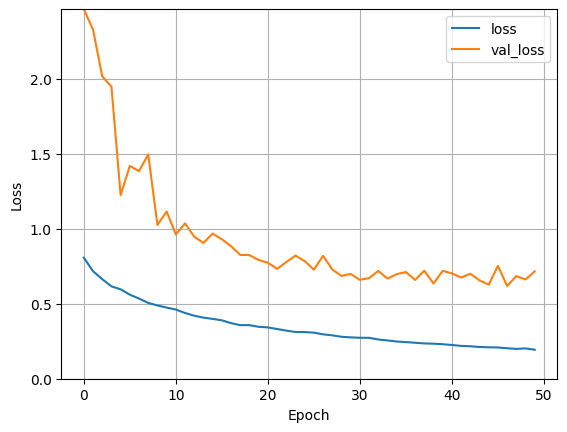

In [84]:
# x: 'Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop','RTTYP_I','RTTYP_M','RTTYP_O','RTTYP_S','RTTYP_U'
# y: 'Collisions_Future'
tf.keras.backend.clear_session()
def create_logistic_model():
    # DENSE LAYERS 
    input = tf.keras.layers.Input(shape=(111335,))
    
    # input = keras.layers.Flatten()(input)

    outputs = keras.layers.Dense(units = 11, activation = 'softmax')(input)

    log_model = tf.keras.models.Model(inputs=input, outputs=outputs, name="logistic_model")

    log_model.summary()

    log_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
        )
    
    return log_model

logistic_model = create_logistic_model()

# class_weight = {0: 100,
#                 1: 10000,
#                 2: 1000,
#                 3: 1000,
#                 4: 100000,
#                 5: 100000,
#                 6: 100000,
#                 7: 100000,
#                 8: 100000,
#                 9: 100000,
#                 10: 100000,
#                }

history = logistic_model.fit(
    input_image_street,
    np.stack(y_train.to_numpy()),
     # y_train_2,
    epochs=50,
    # Suppress logging.
     # verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2,
    class_weight = class_weight
    )

plot_loss(history)

In [85]:
predict_result = history.model.predict(input_image_street_test)

53/53 [==============================] - 0s 5ms/step


In [86]:
predict_result[55]

array([4.4033617e-01, 5.6561071e-04, 4.9316585e-01, 6.5675028e-02,
       1.2843875e-05, 1.9743803e-07, 2.3524281e-04, 7.7390359e-06,
       1.1317383e-06, 1.1162820e-08, 2.5906004e-07], dtype=float32)

In [87]:
predictions = []
for x in range(len(predict_result)):
    predictions.append(np.argmax(predict_result[x]))

    # if len(np.where(predict_result[x]==1)[0])>0:
    #     predictions.append(np.where(predict_result[x]==1)[0][0])
    # else:
    #     predictions.append(-1)

In [88]:
# f1_score(y_test.to_numpy(), predictions, average=None, sample_weight=None, zero_division='warn')
f1_score(y_test.to_numpy(), predictions, average='weighted', sample_weight=None, zero_division='warn')


0.7730922514350921

In [89]:
f1_score(y_test.to_numpy(), predictions, average=None, sample_weight=None, zero_division='warn')

array([0.88037529, 0.1025641 , 0.39786856, 0.24277457, 0.        ,
       0.        , 0.2       , 0.        , 0.        ])

In [90]:
# for real, predicted in zip(y_test['bins_numeric'].to_list(), predictions):
#     print(real,predicted)

In [91]:
print(tiles_expanded_rv['bins_numeric'].value_counts())
print(len(tiles_expanded_rv['bins_numeric'].value_counts()))

0     6644
2     1201
3      283
1      134
6       61
4       26
7       14
5        5
8        4
10       3
9        1
Name: bins_numeric, dtype: int64
11


In [92]:
print(y_test.value_counts())
print(len(y_test.value_counts()))

bins_numeric
0               1347
2                233
3                 53
1                 26
6                  8
4                  4
7                  3
5                  1
8                  1
dtype: int64
9


In [93]:
# len(y_test['bins_numeric'].value_counts())

In [94]:
y_test

,bins_numeric
2732,0
630,0
2887,0
752,0
8106,0
...,...
2156,2
3851,0
4396,0
6110,0


In [95]:
from sklearn.metrics import confusion_matrix

In [96]:
cm = confusion_matrix(y_test['bins_numeric'], predictions)

In [97]:
cm_df = pd.DataFrame(cm,
                     index = [x for x in range(9)],
                     columns = [x for x in range(9)])

In [98]:
cm_df

,0,1,2,3,4,5,6,7,8
0,1126,3,186,32,0,0,0,0,0
1,2,2,8,14,0,0,0,0,0
2,77,4,112,40,0,0,0,0,0
3,6,3,22,21,0,0,1,0,0
4,0,1,0,3,0,0,0,0,0
5,0,0,0,1,0,0,0,0,0
6,0,0,2,5,0,0,1,0,0
7,0,0,0,3,0,0,0,0,0
8,0,0,0,1,0,0,0,0,0


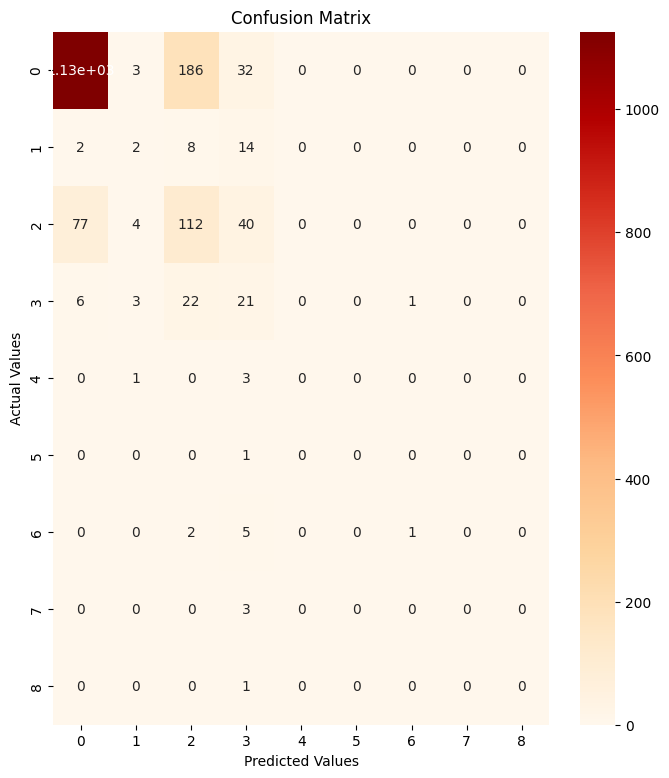

In [99]:
#Plotting the confusion matrix
import seaborn as sns
plt.figure(figsize=(8,9))
sns.heatmap(cm_df, annot=True, fmt='.3g',cmap="OrRd")
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [100]:
cm_df_normalize = cm_df.div(cm_df.sum(axis=1), axis=0)

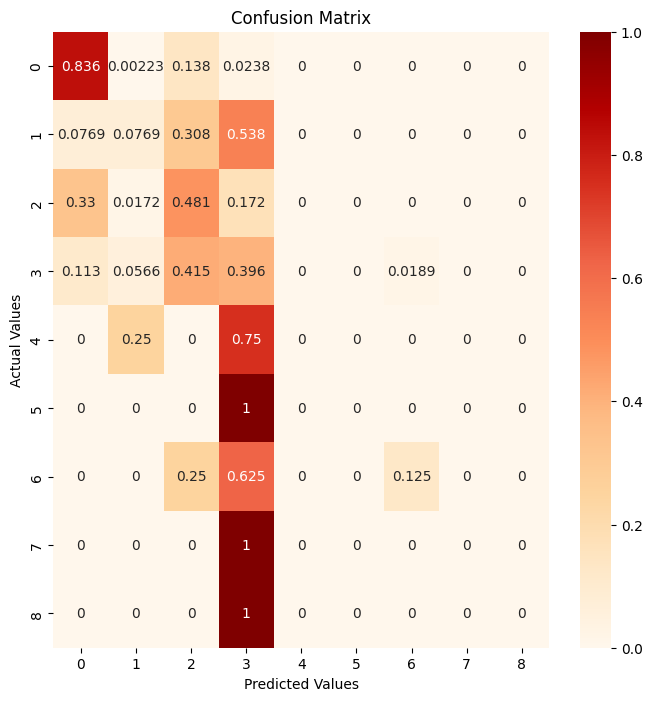

In [101]:
#Plotting the confusion matrix
import seaborn as sns
plt.figure(figsize=(8,8))
sns.heatmap(cm_df_normalize, annot=True, fmt='.3g',cmap="OrRd")
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [102]:
y_test.value_counts()

bins_numeric
0               1347
2                233
3                 53
1                 26
6                  8
4                  4
7                  3
5                  1
8                  1
dtype: int64